In [14]:
# Standard
from collections import namedtuple, deque
# import imageio
# from IPython.display import Image as IPImage
# import os
# from PIL import Image, ImageDraw, ImageFont
import random
from time import sleep

# Third-party
# import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange

# API
from api import KnisterGame

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Definizione QNet

In [16]:
class QNet(nn.Module):
    # Policy Network
    def __init__(self, n_state_vars, n_actions, dim_hidden=64):
        super(QNet, self).__init__()

        # Define a feedforward neural network with hidden layers, ReLU
        #  activations, and an output layer that maps to the number of actions
        self.fc = nn.Sequential(
            # TODO: rivedere architettura rete
            nn.Linear(n_state_vars, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, n_actions),
        )

    def forward(self, x):
        # Passes the input through the network layers to output Q-values
        return self.fc(x)

## Definizione del Replay Buffer

In [17]:
class ReplayBuffer:
    def __init__(self, n_actions, memory_size, batch_size):
        # Initialize actions, batch and experience template
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        # Initialize the memory
        self.memory = deque(maxlen=memory_size) # Hint: use deque

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        # Store experience in memory
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        # Sample a batch of experiences
        experiences = random.sample(self.memory, self.batch_size)  # Hint: use random

        # Convert to tensors for training
        states = torch.from_numpy(
            np.vstack([e.state for e in experiences if e is not None])
        ).float().to(device)

        actions = torch.from_numpy(
            np.vstack([e.action for e in experiences if e is not None])
        ).long().to(device)

        rewards = torch.from_numpy(
            np.vstack([e.reward for e in experiences if e is not None])
        ).float().to(device)

        next_states = torch.from_numpy(
            np.vstack([e.next_state for e in experiences if e is not None])
        ).float().to(device)

        dones = torch.from_numpy(
            np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)
        ).float().to(device)

        # Return the tuple with all tensors (we use the brackets to create a tuple)
        return (states, actions, rewards, next_states, dones)

## Definizione della Deep Q-Network

In [18]:
class DQN:
    def __init__(
        self, n_states, n_actions, batch_size=64, learning_rate=1e-4,
        learn_step=5, gamma=0.99, mem_size=int(1e5), tau=1e-3
    ):
        # Core parameters for learning and updating the Q-network
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma  # Discount factor for future rewards
        self.learn_step = learn_step  # Frequency of learning steps
        self.tau = tau  # Rate for soft updating the target network

        # Initialize the policy network (net_eval) and target network (net_target)
        self.net_eval = QNet(n_states, n_actions).to(device)  # Hint: we have a class for this
        self.net_target = QNet(n_states, n_actions).to(device)  # Hint: we have a class for this
        self.optimizer = optim.Adam(self.net_eval.parameters(), lr=learning_rate)  # Suggestion: use Adam from `optim` with specific learning rate and parameters of the net_eval network
        self.criterion = nn.MSELoss()  # Suggestion: use Mean Squared Error (MSE) as the loss function

        # Initialize memory for experience replay
        self.memory = ReplayBuffer(n_actions, mem_size, batch_size)  # Hint: we have a class for this
        self.counter = 0  # Tracks learning steps for periodic updates

    def getAction(self, state, available_actions, epsilon):
        # Select action using an epsilon-greedy strategy to balance exploration
        #  and exploitation
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.net_eval.eval()  # Set network to evaluation mode
        with torch.no_grad():
            action_values = self.net_eval(state)
        self.net_eval.train()  # Return to training mode

        # Choose random action with probability epsilon, otherwise choose best
        #  predicted action
        # Generiamo un numero R
        if random.random() < epsilon: # random.random rende un numero tra 0 e 1
            action = random.choice(available_actions) # scelgo casualmente l'azione da fare
        else:
            # Calcolo dei q_values
            q_values = action_values.cpu().data.numpy().squeeze()
            # Creiamo una maschera con -infinito
            mask = np.full(q_values.shape, -np.inf)
            
            # Copiamo solo i valori delle azioni VALIDE nella maschera
            mask[available_actions] = q_values[available_actions]
            
            # Argmax sulla maschera sceglierà sempre un'azione valida
            action = np.argmax(mask)
        return action

    def save2Memory(self, state, action, reward, next_state, done):
        # Save experience to memory and, if ready, sample from memory and
        #  update the network
        self.memory.add(state, action, reward, next_state, done)
        self.counter += 1  # Increment step counter

        # Perform learning every 'learn_step' steps if enough experiences are
        #  in memory
        if (self.counter % self.learn_step == 0 and len(self.memory) >= self.batch_size):  # Hint: check if counter is a multiple of learn_step and
                  #  memory has enough samples
            experiences = self.memory.sample()  # Hint: retrieve a sample of experiences
            self.learn(experiences)

    def learn(self, experiences):
        # Perform a learning step by minimizing the difference between
        #  predicted and target Q-values
        states, actions, rewards, next_states, dones = experiences

        # Compute target Q-values from net_target for stability in training
        q_target = self.net_target(next_states).detach().max(1)[0].unsqueeze(1)
        y_j = rewards + (self.gamma * q_target * (1 - dones))
            # Bellman equation for target Q-value
        q_eval = self.net_eval(states).gather(1, actions)
            # Q-value predictions from policy network

        # Compute loss and backpropagate to update net_eval
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network with soft update for smooth learning
        self.targetUpdate()

    def targetUpdate(self):
        # Soft update to gradually shift target network parameters toward
        #  policy network parameters
        params = zip(self.net_eval.parameters(), self.net_target.parameters())
        for eval_param, target_param in params:
            target_param.data.copy_(
                # tau% dei parametri della rete target vengono aggiornati usando i parametri della rete net_eval
                self.tau * eval_param.data + (1.0 - self.tau) * target_param.data # somma pesata dei parametri
            )

## Funzione per il train della rete

In [19]:
CHECKPOINT_NAME = 'checkpoint.pth'
RECENT_EPISODES = 100  # Number of episodes for average score in early stopping
MIN_EPISODES_FOR_STOP = 100  # Ensures enough episodes before evaluating target

def train(
        env, agent, n_episodes, max_steps,
        eps_start, eps_end, eps_decay,
        target_score, do_store_checkpoint
):
    # Initialize score history and epsilon (exploration rate)
    score_hist = []
    epsilon = eps_start
    
    # Progress bar format for tracking training progress
    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt}'\
                 ' [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    pbar = trange(n_episodes, unit="ep", bar_format=bar_format, ascii=True)

    for idx_epi in pbar:
        # Reset the environment for a new episode
        env.new_game()
        env.roll_dice()
        # stato iniziale: griglia e valore dado
        state = np.concatenate((env.get_grid().flatten(), [env.get_current_roll()]))
        score = 0

        for idx_step in range(max_steps):
            # Select an action based on the current policy (epsilon-greedy)
            action = agent.getAction(state, env.get_available_actions(), epsilon)  # Hint: we have something ready for this
            env.choose_action(action)
            # Check if the episode is finished
            if env.has_finished():
                next_dice = 0
            else:
                env.roll_dice()

            next_state = np.concatenate((env.get_grid().flatten(), [env.get_current_roll()]))
            reward = env.get_last_reward()
            done = env.has_finished()

            # Store experience in memory and update the agent
            agent.save2Memory(state, action, reward, next_state, done)  # Hint: what data do we store as "experience"? How we do it?
            state = next_state  # Move to the next state
            score += reward  # Hint: what's our total cumulative score?
            if done:
                break

        # Track scores and decay epsilon for less exploration over time
        score_hist.append(score)
        score_avg = np.mean(score_hist[-RECENT_EPISODES:])
        epsilon = max(epsilon * eps_decay, eps_end)  # Hint: epsilon decreases, but we have a minimum

        # Update the progress bar with the current score and average
        pbar.set_postfix_str(
            f"Score: {score: 7.2f}, 100 score avg: {score_avg: 7.2f}"
        )
        pbar.update(0)

        # Early stopping condition if target score is achieved
        if len(score_hist) >= 100 and score_avg >= target_score:
            print("\nTarget Reached!")
            break

    # Print completion message based on early stopping or max episodes
    if (idx_epi + 1) < n_episodes:
        print("\nTraining complete - target reached!")
    else:
        print("\nTraining complete - maximum episodes reached.")

    # Save the trained model if specified
    if do_store_checkpoint:
        torch.save(agent.net_eval.state_dict(), CHECKPOINT_NAME)

    return score_hist

## Funzione per il test della rete

In [ ]:
def testKnister(env, agent, num_tests, max_steps):
    # Run the agent in the environment for the specified number of test episodes
    total_rewards = []
    bar_format = '{l_bar}{bar:10}| {n:4}/{total_fmt}'\
                 ' [{elapsed:>7}<{remaining:>7}, {rate_fmt}{postfix}]'
    pbar = trange(num_tests, unit="ep", bar_format=bar_format, ascii=True)
    for idx_epi in pbar:
        env.new_game()
        env.roll_dice()
        state = np.concatenate((env.get_grid().flatten(), [env.get_current_roll()]))
        episode_reward = 0

        for idx_step in range(max_steps):
            # Select action without exploration for deterministic behavior
            action = agent.getAction(state, env.get_available_actions(), epsilon=0)  # Hint: be careful choosing epsilon (in questo modo visto che siamo in test scegliamo l'azione migliore)
            env.choose_action(action)
            # Perform the action and observe the next state and reward
            state = np.concatenate((env.get_grid().flatten(), [env.get_current_roll()]))
            reward = env.get_last_reward()
            episode_reward += reward

            done = env.has_finished()

            # End episode if the agent reaches a terminal state
            if done:
                break
        
        total_rewards.append(episode_reward)
        pbar.set_postfix_str(
            f"Score: {episode_reward: 7.2f}, 100 score avg: {np.mean(total_rewards[-100:]): 7.2f}"
        )
        
    print(f"\nTest complete! Average Test Reward: {np.mean(total_rewards): .2f}")


In [21]:
def plotScore(scores):
    # Plot the agent's score history to visualize learning progress
    plt.figure()
    plt.plot(scores)
    plt.title("Score History")
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.show()

## Definizione Parametri

In [22]:
BATCH_SIZE = 128         # Number of experiences sampled per learning step (32, 64, 128)
LR = 1e-3               # Learning rate for optimizer (1e-3, 1e-4)
EPISODES = 10000        # Maximum number of episodes to train (~1 or 2 minute for 100 episodes)
TARGET_SCORE = 70       # Early stop if average score reaches this value (punteggio che dovrebbe fare la navetta quando atterra)
GAMMA = 0.99            # Discount factor for future rewards
MEMORY_SIZE = 10000     # Maximum capacity of replay memory (multiplo di mille)
LEARN_STEP = 5          # Frequency (in steps) of learning updates (5, 10)
TAU = 1e-3              # Soft update rate for the target network (1e-3)
SAVE_CHKPT = False      # Option to save trained model checkpoint

# Exploration parameters
MAX_STEPS = 3000        # Maximum steps per episode
EPS_START = 1           # Initial epsilon for exploration (100% exploration at start)
EPS_END = 0.1          # Minimum epsilon (final exploration rate)
EPS_DECAY = 0.9        # Epsilon decay rate (controls exploration reduction)

## Train della rete

  0%|          |    0/10000 [  00:00<      ?, ?ep/s, Score:   11.00, 100 score avg:   11.00]

100%|##########| 10000/10000 [  05:42<  00:00, 29.21ep/s, Score:   15.00, 100 score avg:   19.72]



Training complete - maximum episodes reached.


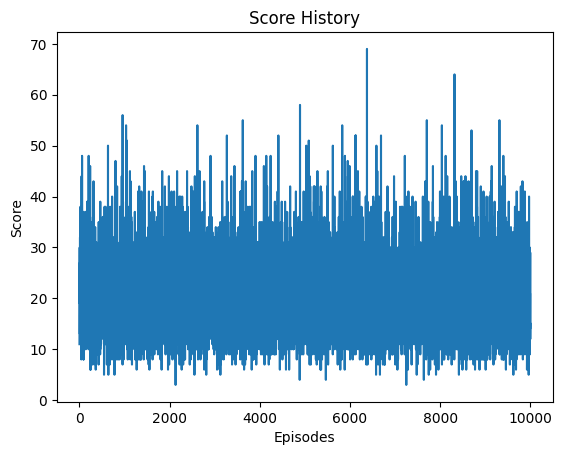

In [23]:
# TODO: Riadattare a knister
# Initialize the Knister environment
env = KnisterGame()

# Determine the number of states and actions in the environment
num_states = 26 # numero di caselle della griglia più 1 per il dado
num_actions = 25

# Initialize the DQN agent with customizable parameters
agent = DQN(
    n_states = num_states,
    n_actions = num_actions,
    batch_size = BATCH_SIZE,
    learning_rate = LR,
    gamma = GAMMA,
    mem_size = MEMORY_SIZE,
    learn_step = LEARN_STEP,
    tau = TAU,
)

# Train the agent using the train function and record the score history
score_hist = train(
    env, agent, n_episodes=EPISODES, max_steps=MAX_STEPS,
    eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY,
    target_score=TARGET_SCORE, do_store_checkpoint=SAVE_CHKPT
)

# Plot the score history to visualize training progress over episodes
plotScore(score_hist)

# Free up GPU memory if using CUDA
if str(device) == "cuda":
    torch.cuda.empty_cache()

## Test della rete su 500 match

In [24]:
NUM_TEST_EPISODES = 500  # Number of episodes to test the agent
MAX_STEPS_TEST = 30    # Maximum steps per test episode

# Run the trained agent for a series of test episodes
testKnister(env, agent, num_tests=NUM_TEST_EPISODES, max_steps=MAX_STEPS_TEST)

100%|##########|  500/500 [  00:05<  00:00, 88.66ep/s, Score:   11.00, 100 score avg:   20.06]


Test complete! Average Test Reward:  19.88
